# Project 03: ij-blocking / Caches and Data Locality
Version edition:11Sep

In [1]:
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


## Loop fusion

We first define the method we will be using to validate the output of the stencil2d program below.

In [3]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

Compile the files, including original, kblocking, and ij-blocking (named xy here)

In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=orig
make VERSION=kblocking
make VERSION=xy
make VERSION=inlining

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-kblocking.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x
cp stencil2d-kblocking.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-xy.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-xy.o -o stencil2d-xy.x
cp stencil2d-xy.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-inlining.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-inlining.o -o stencil2d-inlining.x
cp stencil2d-inlining.x stencil2d.x


## ij-blocking test experiments:

### Varying mx, my. 
Output = Table of computational time at different mx, my.

In [ ]:
%%bash

#EDIT the desired loop variables here=========================
#If we are lazy, just adjust the followings:
domain_length=64   #assuming square domain
fixed_mx=false # Change to "true" or "false" as needed
fixed_my=false # Change to "true" or "false" as needed

#### If they are not fixed, they check through a series of mx or my
#### See below for more details
#### Example: says domain_length=4
#### fixed_mx=true; fixed_my=true
#### This gives a result of mx=4,my=4
####
#### fixed_mx=true; fixed_my=false
#### This gives a result of mx=4,my=1,2,4
####
#### fixed_mx=false; fixed_my=false
#### This gives a result of mx=1,2,4,my=1,2,4
#### This will indeed give the most general results
#### The following graphs and scripts are produced based on the these results
#### ----------------------------------------

nx=$domain_length   #assuming square domain
ny=$domain_length   #assuming square domain
nz=4 #For simplification
num_iter=128 #For simplification

#max mx and my length
#Set to the desired value if needed
mx_max=$domain_length; my_max=$domain_length

#min mx and my length
mx_min=1; my_min=1 # Set to the desired value when fixed_mx is false


if [ "$fixed_mx" = true ] && [ "$fixed_my" = true ]; then
    my_min=$my_max
    mx_min=$mx_max
    #Set output file name:
    output_file="data/result_stencil2d-xy${domain_length}_fixedmxmy.txt"
    > "$output_file"
elif [ "$fixed_mx" = true ]; then
    mx_min=$mx_max
    #Set output file name:
    output_file="data/result_stencil2d-xy${domain_length}_fixedmx.txt" 
    > "$output_file"
elif [ "$fixed_my" = true ]; then
    my_min=$my_max
    #Set output file name:
    output_file="data/result_stencil2d-xy${domain_length}_fixedmy.txt"
    > "$output_file"
else
    #Set output file name:
    output_file="data/result_stencil2d-xy${domain_length}.txt"
    > "$output_file"
fi

#Initializing the header (time as the computational time)
echo "mx,my,time" >> "$output_file"
#===============================================================

#Generating a for loop list with 2**n-------------
# Define a function to calculate log2 which returns **integer values only**
log2() {
    local number="$1"
    local result
    result=$(echo "l($number)/l(2)" | bc -l | xargs printf "%.0f")
    echo "$result"
}
# Define the lists
idx_mx_min=$(log2 $mx_min); idx_mx_max=$(log2 $mx_max)
idx_my_min=$(log2 $my_min); idx_my_max=$(log2 $my_max)

#list generation
for ((nn = idx_mx_min; nn <= idx_mx_max; nn++)); do
    values=$((2 ** nn))
    i_ls="${i_ls} $values"
done
for ((nn = idx_my_min; nn <= idx_my_max; nn++)); do
    values=$((2 ** nn))
    j_ls="${j_ls} $values"
done
#-------------------------------------------------

#Start the iteration------------------------------
for j in $j_ls; do
echo "$j start" #record tracking
    for i in $i_ls ; do

    #iteration
    #Note, nz = 4
    srun_output=$(srun -n 12 ./stencil2d-xy.x --nx $nx --ny $ny --nz $nz --mx $i --my $j --num_iter $num_iter)

    # Use grep to extract the floating-point number, which is the computational time
    floating_number=$(echo "$srun_output" | grep -oE '[0-9]+\.[0-9]+[Ee][-+]?[0-9]+')

    # Save the extracted number to the specified file
    #mx, my, time are saved in the file
    echo "$i,$j,$floating_number" >> "$output_file"
    done
echo "$j end" #record tracking
done

1 start


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


1 end
2 start


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


2 end
4 start
4 end
8 start


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


8 end
16 start
16 end
32 start
32 end
64 start
64 end


### Quick Individual checking

In [62]:
%%bash
srun -n 12 ./stencil2d-xy.x --nx 64 --ny 64 --nz 4 --mx 1 --my 1 --num_iter 128

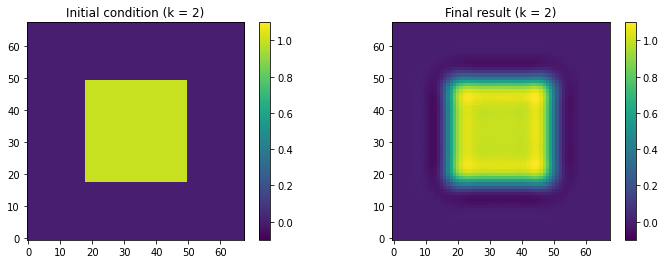

In [63]:
validate_results()

### Changing domain shape with fixed size

In [227]:
%%bash
#domain size = domain_length**2
domain_length=64
output_file="data/domain_${domain_length}.txt"
#Initializing the header (time as the computational time)
echo "nx,ny,time" > "$output_file"

# Define a function to calculate log2 which returns **integer values only**
log2() {
    local number="$1"
    local result
    result=$(echo "l($number)/l(2)" | bc -l | xargs printf "%.0f")
    echo "$result"
}

p=$(log2 $((domain_length*domain_length)))

for ((power = 0; power <= $p; power++)); do
  nx=$((2**power))
  ny=$((2**($p-power)))
  echo "Running with nx=$nx, ny=$ny and saving output to $output_file"
  srun_output=$(srun -n 12 ./stencil2d-inlining.x --nx $nx --ny $ny --nz 4 --num_iter 128)
  floating_number=$(echo "$srun_output" | grep -oE '[0-9]+\.[0-9]+[Ee][-+]?[0-9]+')
  #floating_number=$(echo "$srun_output")
  echo "floating_number for nx=$nx, ny=$ny: $floating_number"
  echo "$nx,$ny,$floating_number" >> "$output_file"
done

Running with nx=1, ny=4096 and saving output to data/domain_64.txt
floating_number for nx=1, ny=4096: 0.3459815E-01
Running with nx=2, ny=2048 and saving output to data/domain_64.txt
floating_number for nx=2, ny=2048: 0.2277551E-01
Running with nx=4, ny=1024 and saving output to data/domain_64.txt


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


floating_number for nx=4, ny=1024: 0.1454055E-01
Running with nx=8, ny=512 and saving output to data/domain_64.txt


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


floating_number for nx=8, ny=512: 0.5806784E-02
Running with nx=16, ny=256 and saving output to data/domain_64.txt


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


floating_number for nx=16, ny=256: 0.3733079E-02
Running with nx=32, ny=128 and saving output to data/domain_64.txt
floating_number for nx=32, ny=128: 0.2658625E-02
Running with nx=64, ny=64 and saving output to data/domain_64.txt
floating_number for nx=64, ny=64: 0.1941423E-02
Running with nx=128, ny=32 and saving output to data/domain_64.txt
floating_number for nx=128, ny=32: 0.1749118E-02
Running with nx=256, ny=16 and saving output to data/domain_64.txt
floating_number for nx=256, ny=16: 0.1667142E-02
Running with nx=512, ny=8 and saving output to data/domain_64.txt
floating_number for nx=512, ny=8: 0.1912177E-02
Running with nx=1024, ny=4 and saving output to data/domain_64.txt
floating_number for nx=1024, ny=4: 0.2133310E-02
Running with nx=2048, ny=2 and saving output to data/domain_64.txt


srun: Job 48876879 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48876879


floating_number for nx=2048, ny=2: 0.2821962E-02
Running with nx=4096, ny=1 and saving output to data/domain_64.txt
floating_number for nx=4096, ny=1: 0.5226572E-02


### Results from kblocking only

In [ ]:
output_file="data/output_kblocking.txt"
#Initializing the header (time as the computational time)
echo "nx,ny,time" > "$output_file"

#From 64 to 8192
for ((power = 6; power <= 13; power++)); do
  nx=$((2**power))
  ny=$nx #square
  echo "Running with nx=$nx, ny=$ny and saving output to $output_file"
  srun_output=$(srun -n 12 ./stencil2d-kblocking.x --nx $nx --ny $ny --nz 4 --num_iter 128)
  floating_number=$(echo "$srun_output" | grep -oE '[0-9]+\.[0-9]+[Ee][-+]?[0-9]+')
  echo "floating_number for power $power: $floating_number"
  echo "$power,$floating_number" >> "$output_file"
done

## Plotting results from fixed mx, varying my or fixed my, varying mx

1. Self-normalized computational Time needed for varying my with fixed mx = nx (num_iter = 128)
2. Computational time per grid point needed for varying my with fixed mx = nx (num_iter = 128)
3. Performance comparison with kblocking

In [5]:
# Initializing tags
name_ls = []
n = np.arange(6,13+1)
size = 2**n
for i in range(len(n)):
    name_ls = name_ls+[str(size[i])]
# Note that due to large computational time, for 8192x8192, not all combinations are computed.

#Read data
da = np.loadtxt("data/result_stencil2d-xy"+name_ls[0]+".txt", delimiter=",",skiprows=1)
mxmy = ['mx','my']

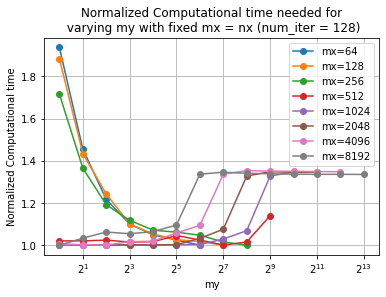

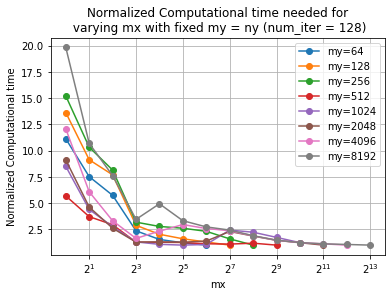

In [147]:
for fixed in mxmy:
    fig,ax1 = plt.subplots()
    #Computational time per grid point needed
    for i in range(len(name_ls)):
        da = np.loadtxt("data/result_stencil2d-xy"+name_ls[i]+".txt", delimiter=",",skiprows=1)
        da_mx = da[:,0]
        da_my = da[:,1]
        da_t = da[:,-1]
        
        if fixed == 'mx':
            fixed_size = 'nx'; varying = 'my'
            fixed_idx = np.where(da_mx==da_mx.max())
            varying_axis = da_my[fixed_idx]
        else:
            fixed_size = 'ny'; varying = 'mx'
            fixed_idx = np.where(da_my==da_my.max())
            varying_axis = da_mx[fixed_idx]
            
        #Normalized Computational time
        t_norm = (da_t[fixed_idx]/np.min(da_t[fixed_idx]))
        ax1.plot(varying_axis,t_norm,marker='o',label=fixed+'='+name_ls[i])

    ax1.set_xscale('log',base=2)
    ax1.grid()
    ax1.legend()
    ax1.set_ylabel(r'Normalized Computational time')
    ax1.set_xlabel(varying)
    ax1.set_title('Normalized Computational time needed for\n varying '+varying+' with fixed '+fixed+' = '+fixed_size+' (num_iter = 128)')
    fig.savefig('fig/fixed_'+fixed+'_tn.png',dpi=200)

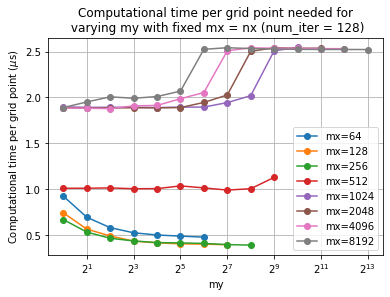

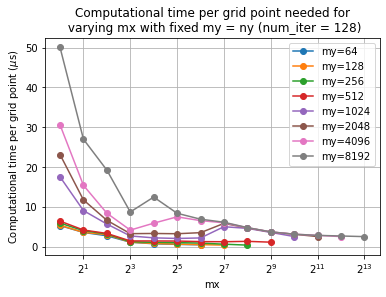

In [23]:
for fixed in mxmy:
    fig,ax1 = plt.subplots()
    #Computational time per grid point needed
    for i in range(len(name_ls)):
        da = np.loadtxt("data/result_stencil2d-xy"+name_ls[i]+".txt", delimiter=",",skiprows=1)
        da_mx = da[:,0]
        da_my = da[:,1]
        da_t = da[:,-1]
        
        if fixed == 'mx':
            fixed_size = 'nx'; varying = 'my'
            fixed_idx = np.where(da_mx==da_mx.max())
            varying_axis = da_my[fixed_idx]
        else:
            fixed_size = 'ny'; varying = 'mx'
            fixed_idx = np.where(da_my==da_my.max())
            varying_axis = da_mx[fixed_idx]
            
        #Computational time per grid point needed
        #get micro-second in time unit
        t_per_grid = (da_t[fixed_idx]/(da_mx.max()*da_my.max()))*1E6
        ax1.plot(varying_axis,t_per_grid,marker='o',label=fixed+'='+name_ls[i])

    ax1.set_xscale('log',base=2)
    ax1.grid()
    ax1.legend()
    ax1.set_ylabel(r'Computational time per grid point ($\mu$s)')
    ax1.set_xlabel(varying)
    ax1.set_title('Computational time per grid point needed for\n varying '+varying+' with fixed '+fixed+' = '+fixed_size+' (num_iter = 128)')
    fig.savefig('fig/fixed_'+fixed+'_tpg.png',dpi=200)

In [19]:
#Load k-blocking perfermance
da_kb = np.loadtxt('data/output_kblocking.txt',delimiter=',')
da_kb_nx = 2**da_kb[:,0]
da_kb_ny = 2**da_kb[:,0]
da_kb_t = da_kb[:,-1]

array([1.889129e-03, 6.421268e-03, 2.630589e-02, 2.903822e-01,
       2.665620e+00, 1.062798e+01, 4.240214e+01, 1.689954e+02])

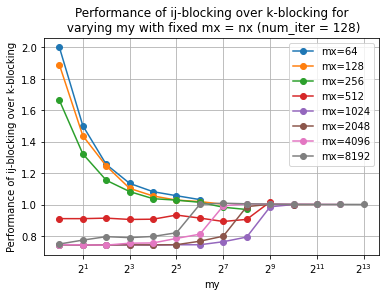

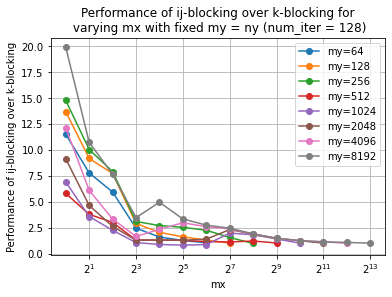

In [24]:
for fixed in mxmy:
    fig,ax1 = plt.subplots()
    #Computational time per grid point needed
    for i in range(len(name_ls)):
        da = np.loadtxt("data/result_stencil2d-xy"+name_ls[i]+".txt", delimiter=",",skiprows=1)
        da_mx = da[:,0]
        da_my = da[:,1]
        da_t = da[:,-1]
        
        if fixed == 'mx':
            fixed_size = 'nx'; varying = 'my'
            fixed_idx = np.where(da_mx==da_mx.max())
            varying_axis = da_my[fixed_idx]
        else:
            fixed_size = 'ny'; varying = 'mx'
            fixed_idx = np.where(da_my==da_my.max())
            varying_axis = da_mx[fixed_idx]
            
        #Computational time of ij-blocking/k-blocking
        t_kb = da_t[fixed_idx]/da_kb_t[i]
        ax1.plot(varying_axis,t_kb,marker='o',label=fixed+'='+name_ls[i])

    ax1.set_xscale('log',base=2)
    ax1.grid()
    ax1.legend()
    ax1.set_ylabel(r'Performance of ij-blocking over k-blocking')
    ax1.set_xlabel(varying)
    ax1.set_title('Performance of ij-blocking over k-blocking for\n varying '+varying+' with fixed '+fixed+' = '+fixed_size+' (num_iter = 128)')
    fig.savefig('fig/fixed_'+fixed+'_performance.png',dpi=200)

4. Contour maps for runtime per grid cell in mx-my space

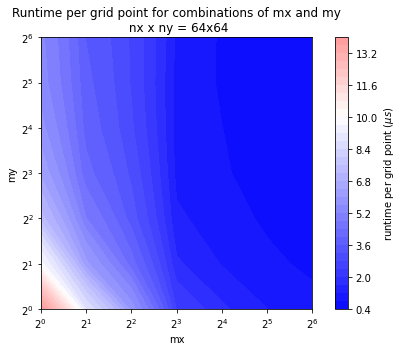

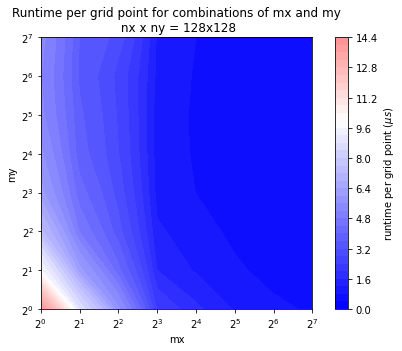

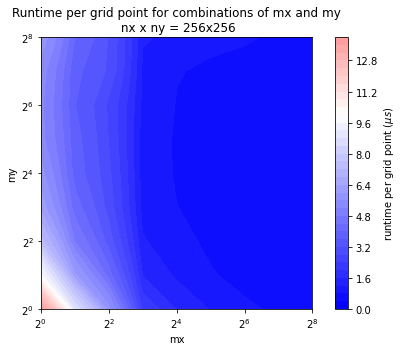

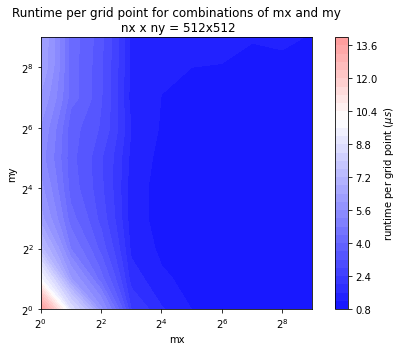

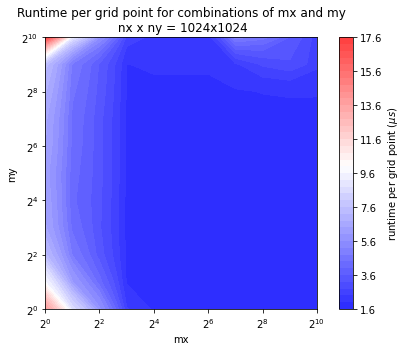

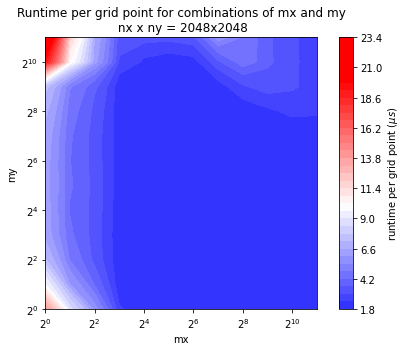

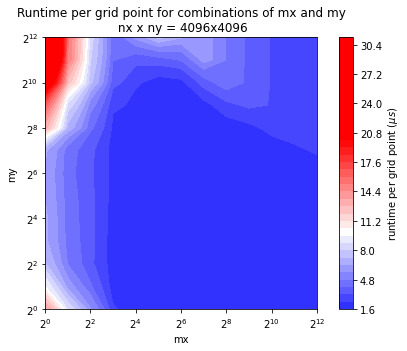

In [196]:
for i in range(len(name_ls)-1): #Skipped the case for 8192x8192
    da = np.loadtxt("data/result_stencil2d-xy"+name_ls[i]+".txt", delimiter=",",skiprows=1)
    da_mx = da[:,0]
    da_my = da[:,1]
    da_t = da[:,-1]
    
    #Computational time per grid point needed
    #get micro-second in time unit
    da_t_ = (da_t/(da_mx.max()*da_my.max()))*1E6
    #Reshape the array for plotting contourf
    da_t_tmp = da_t_.reshape(len(np.unique(da_mx)),len(np.unique(da_my)))

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_box_aspect(1)
    ct = ax.contourf((np.unique(da_mx)),(np.unique(da_my)),da_t_tmp,cmap='bwr',vmin=0,vmax=20,levels=40)
    cb = fig.colorbar(ct,ax=ax,label=r'runtime per grid point ($\mu s$)')
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_xlabel('mx')
    ax.set_ylabel('my')
    ax.set_title(f'Runtime per grid point for combinations of mx and my\n nx x ny = {name_ls[i]}x{name_ls[i]}')
    fig.savefig(f'fig/combination_{name_ls[i]}.png',dpi=200)

## Runtime per grid points under diff shape of domain with the same total points

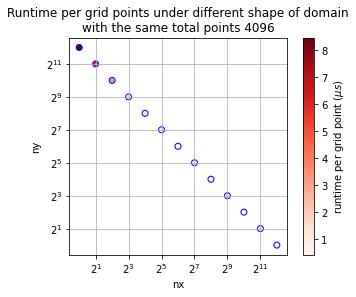

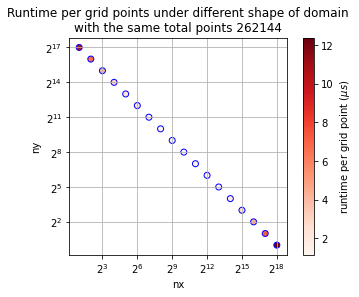

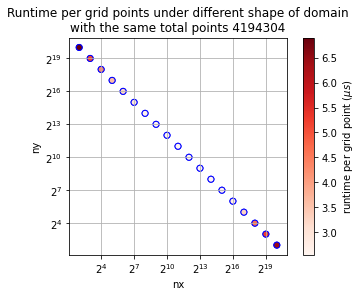

In [7]:
num_ls = [64,512,2048]
for i in num_ls:
    da = np.loadtxt(f"data/domain_{str(i)}.txt",delimiter=',',skiprows=1)
    da_nx = da[:,0]
    da_ny = da[:,1]
    da_t_in = da[:,-1]

    fig,ax1 = plt.subplots()
    ax1.set_box_aspect(1)
    sct = ax1.scatter(da_nx,da_ny,c=(da_t_in/(i**2))*1E6,marker='o',cmap='Reds')
    fig.colorbar(sct, ax=ax1,label=r'runtime per grid point ($\mu s$)')
    ax1.set_xticks(da_nx)
    ax1.set_xscale('log',base=2)
    ax1.set_yscale('log',base=2)
    ax1.grid()
    ax1.set_ylabel('ny')
    ax1.set_xlabel('nx')
    ax1.set_title(f'Runtime per grid points under different shape of domain\nwith the same total points {i*i}')
    fig.savefig(f'fig/domain_{str(i)}.png',dpi=200)